In [48]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
import matplotlib.pyplot as plt

In [49]:
insurance_train = pd.read_csv("insurance_t.csv")
insurance_validation = pd.read_csv('insurance_v.csv')

In [ ]:
categorical_columns = ['MMCRED', 'CCPURC', 'DDA', 'DIRDEP', 'NSF', 'SAV', 'ATM', 'CD', 'IRA', 'INV', 'MM', 'CC', 'SDB', 'INAREA', 'INS', 'BRANCH']
continuous_columns = [col for col in insurance_train.columns if col not in categorical_columns]

for col in categorical_columns:
    insurance_train[col] = pd.Categorical(insurance_train[col])
    insurance_validation[col] = pd.Categorical(insurance_validation[col])

# Impute missing values
for col in continuous_columns:
    imputer = SimpleImputer(strategy='median')
    insurance_train[col] = imputer.fit_transform(insurance_train[[col]])
    insurance_validation[col] = imputer.transform(insurance_validation[[col]])

for col in ['CC', 'INV', 'CCPURC']:
    imputer = SimpleImputer(strategy='most_frequent')
    insurance_train[col] = imputer.fit_transform(insurance_train[[col]])
    insurance_validation[col] = imputer.transform(insurance_validation[[col]])

# One-hot encode categorical variables
insurance_train_encoded = pd.get_dummies(insurance_train, columns=categorical_columns, drop_first=True)
insurance_validation_encoded = pd.get_dummies(insurance_validation, columns=categorical_columns, drop_first=True)

# Ensure both datasets have the same columns
train_columns = set(insurance_train_encoded.columns)
val_columns = set(insurance_validation_encoded.columns)
missing_cols = train_columns - val_columns
for col in missing_cols:
    insurance_validation_encoded[col] = 0
insurance_validation_encoded = insurance_validation_encoded[insurance_train_encoded.columns]

In [51]:
train_columns == val_columns

False

In [52]:
insurance_train = insurance_train[insurance_train['MMCRED'] != 5]

In [53]:
train_columns = set(insurance_train_encoded.columns)
val_columns = set(insurance_validation_encoded.columns)

In [ ]:
# Step 3: Check for duplicate columns 
duplicate_train = insurance_train.columns[insurance_train.columns.duplicated()]
duplicate_val = insurance_validation.columns[insurance_validation.columns.duplicated()]

print("Duplicate columns in training set:", duplicate_train.tolist())
print("Duplicate columns in validation set:", duplicate_val.tolist())

Duplicate columns in training set: []
Duplicate columns in validation set: []


In [ ]:
X_train = insurance_train_encoded.drop('INS_1', axis=1)
y_train = insurance_train_encoded['INS_1']
X_val = insurance_validation_encoded.drop('INS_1', axis=1)
y_val = insurance_validation_encoded['INS_1']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)



In [ ]:
from tensorflow.keras.layers import Input

# Define model with Input layer
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), 
                    epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping])

# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train_scaled, y_train, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6154 - loss: 0.6805 - val_accuracy: 0.6831 - val_loss: 0.5814
Epoch 2/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6963 - loss: 0.5886 - val_accuracy: 0.6996 - val_loss: 0.5679
Epoch 3/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7187 - loss: 0.5589 - val_accuracy: 0.7010 - val_loss: 0.5636
Epoch 4/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7265 - loss: 0.5527 - val_accuracy: 0.7114 - val_loss: 0.5574
Epoch 5/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7265 - loss: 0.5516 - val_accuracy: 0.7100 - val_loss: 0.5532
Epoch 6/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7276 - loss: 0.5381 - val_accuracy: 0.7105 - val_loss: 0.5495
Epoch 7/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7309 - loss: 0.5395 - val_accuracy: 0.7194 - val_loss: 0.5446
Epoch 8/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7432 - loss: 0.5266 - val_accu

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation ROC AUC: 0.7876


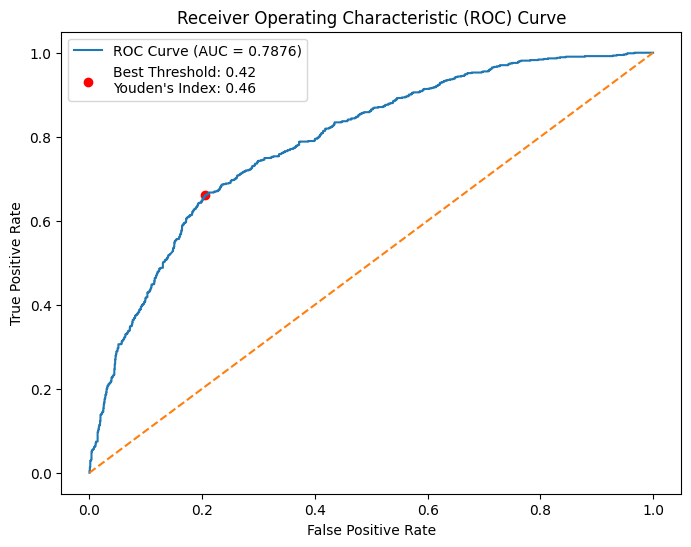

In [ ]:
# Calculate ROC AUC and plot ROC curve
y_pred_val_probs = model.predict(X_val_scaled)  # already gives probabilities
val_auc = roc_auc_score(y_val, y_pred_val_probs)

print(f"Validation ROC AUC: {val_auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_probs)
# Calculate Youden's Index 
youden_index = tpr - fpr

max_index = youden_index.argmax()

# Get the corresponding TPR, FPR, and threshold
best_threshold = thresholds[max_index]
best_tpr = tpr[max_index]
best_fpr = fpr[max_index]
best_youden_index = youden_index[max_index]

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_val, y_pred_val_probs):.4f})')
plt.scatter(best_fpr, best_tpr, color='red', label=f'Best Threshold: {best_threshold:.2f}\nYouden\'s Index: {best_youden_index:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()



In [ ]:
# Custom scoring function for permutation importance using AUC
def custom_scorer(estimator, X, y):
    y_pred_probs = estimator.predict(X).ravel()
    return roc_auc_score(y, y_pred_probs)

from sklearn.inspection import permutation_importance

# Feature importance
result = permutation_importance(
    estimator=model,
    X=X_val_scaled,
    y=y_val,
    n_repeats=10,
    random_state=42,
    scoring=custom_scorer 
)

feature_importance_df = pd.DataFrame({'feature': X_val.columns, 'importance': result.importances_mean})

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
67/67 ━━━━━━━━━━━━━━━━

In [64]:
print(feature_importance_df.sort_values(by='importance', ascending=False).head(10))


       feature  importance
8       SAVBAL    0.077269
1       DDABAL    0.050442
30       DDA_1    0.018839
9       ATMAMT    0.013829
33       SAV_1    0.011916
35        CD_1    0.009206
7       TELLER    0.009056
15       MMBAL    0.008833
36       IRA_1    0.008444
47  BRANCH_B15    0.007023
